# Tutorial Fourier ptychographic microscopy

### Tutor: Julio C. da Silva (Néel Institute CNRS, Grenoble, France) /  email: julio-cesar.da-silva@neel.cnrs.fr
#### Personal webpage: https://sites.google.com/view/jcesardasilva

##### Disclaimer: This notebook is intended from educational reasons only and should not be use for professional data analysis. For the latter, there are other more efficient and complete codes available.

This code run in **Python3** and requires certain python packages, which are: **Numpy, IPython, Matplotlib, Scikit-Image**

If you do not have those packages, I suggest their installation via pip install: 

    pip3 install numpy, ipython, matplotlib, scikit-image

# Ptychographic phase retrieval
This code is deeply inspired by the MATLAB code available in the book "**Fourier Ptychographic Ptychographic Imaging: A MATLAB tutorial**" by Guoan Zheng: https://iopscience.iop.org/book/978-1-6817-4273-1.pdf

This notebook uses local python routines which are in the same folder as this notebook. 

In [1]:
%matplotlib inline
# standard python package
import itertools
import time

# third party packages
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import skimage.data as data
from skimage.io import imread, use_plugin
from skimage.transform import resize

# local packages
from generators import generateseq, generate_CTF

## Forward FPM
This function will simulation the process of imaging of Fourier ptychography, i.e., will simulate the data acquisition.

In [24]:
def forward_fpm(obj,arraysize,waveLength,spsize,psize,NA,LEDgap,LEDheight,epsilon=0.5,display=False):
    """
    simulate the forward imaging process of Fourier ptychography
    """

    ## setup the parameters for the coherent imaging system
    k0 = 2*np.pi/waveLength

    ## generate the low-pass filtered images
    m,n = obj.shape # image size of the high resolution object
    m1 = int(m/(spsize/psize)) # spsize/psize = 4
    n1 = int(n/(spsize/psize)) # image size of the final output
    imSeqLowRes = np.zeros((arraysize**2, m1, n1)) # stores output low-resolution image stack
    
    obj_shape = obj.shape
    CTF, kx, dkx, ky, dky= generate_CTF(obj_shape,arraysize,waveLength,spsize,psize,NA,LEDgap,LEDheight)
    objectFT = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj))) #(256 x 256)
    
    if display:
        plt.close('all')
        plt.ion()
        fig1 = plt.figure(1)
        ax1 = fig1.add_subplot(111)
        fig2 = plt.figure(2)
        ax2 = fig2.add_subplot(111)
        fig3 = plt.figure(3)
        ax3 = fig3.add_subplot(111)
    for ii in np.arange(arraysize**2):
        print('Image {}\r'.format(ii+1),end=" ")
        kxc = np.round(n/2+kx[ii]/dkx) #kxc = np.round(n/2+kx[0,ii]/dkx) #original
        kyc = np.round(m/2+ky[ii]/dky) #kyc = np.round(m/2+ky[0,ii]/dky) #original
        ky1 = np.round(kyc-(m1)/2.).astype('int')
        kyh = np.round(kyc+(m1)/2.).astype('int')
        kx1 = np.round(kxc-(n1)/2.).astype('int')
        kxh = np.round(kxc+(n1)/2.).astype('int')
        imSeqLowFT = (m1/m)**2 * objectFT[ky1:kyh,kx1:kxh]*CTF
        cmin = 0#np.min(np.log(np.abs((m1/m)**2 * objectFT[ky1:kyh,kx1:kxh])))-epsilon
        cmax = np.max(np.log(np.abs((m1/m)**2 * objectFT[ky1:kyh,kx1:kxh])))
        imSeqLowRes[ii] = np.abs(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(imSeqLowFT))))**2 # add the power 2 or not
        if display:
            if ii==0:
                im1=ax1.imshow(np.log(np.abs(imSeqLowFT)+epsilon),cmap='jet',vmin=0,vmax=cmax)
                ax1.set_title(u'Fourier transform domain. Image {}'.format(ii+1))
                im2=ax2.imshow(imSeqLowRes[ii],cmap='gray')
                ax2.set_title(u'Low resolution image {}'.format(ii+1))
                im3=ax3.imshow(np.log(np.abs(objectFT[ky1:kyh,kx1:kxh])+epsilon),cmap='jet')#,vmin=0,vmax=cmax)
                ax3.set_title(u'Full Fourier transform domain. Image {}'.format(ii+1))
            else:
                im1.set_data(np.log(np.abs(imSeqLowFT)+epsilon))
                ax1.set_title(u'Fourier transform domain. Image {}'.format(ii+1))
                im1.set_clim(cmin,cmax)
                im2.set_data(imSeqLowRes[ii])
                ax2.set_title(u'Low resolution image {}'.format(ii+1))
                im2.set_clim(imSeqLowRes[ii].min(),imSeqLowRes[ii].max())
                im3.set_data(np.log(np.abs(objectFT[ky1:kyh,kx1:kxh])+epsilon))
                ax3.set_title(u'Full Fourier transform domain. Image {}'.format(ii+1))
                #im3.set_clim(cmin,cmax)
            im1.axes.figure.canvas.draw()
            im2.axes.figure.canvas.draw()
            im3.axes.figure.canvas.draw()
            plt.pause(0.0001)
    if display:
        plt.ioff()
    return imSeqLowRes

## Phase recovery in FPM
This function will carry out the phase retrieval yield the high resolution images after processing the raw (simulated) data.

In [66]:
def recovery_fpm(imSeqLowRes,arraysize,nloop,waveLength,spsize,psize,NA,LEDgap,LEDheight,epsilon = 0.1):
    """
    recover the high resolution image
    """
    _,m1,n1 = imSeqLowRes.shape # size of the input low resolution images
    resolutionFactor = np.round(spsize/psize).astype(int) # factor of improvement in resolution (needs to be integer)
    m ,n  = resolutionFactor*np.array([m1,n1]) # size of the output high resolution image
    obj_shape = (m,n)

    # generate CTF and k-vectors    
    CTF, kx, dkx, ky, dky = generate_CTF(obj_shape,arraysize,waveLength,spsize,psize,NA,LEDgap,LEDheight)
    #CTF[np.where(CTF)==0] = 0.8
    # define the order of recovery, we start from the center (the 113rd image) to the edge of the spectrum (the 225th image)
    seqimg = generateseq(arraysize) 

    # initial guess of the object
    objectRecover = np.ones((m,n))
    objectRecoverFT = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(objectRecover)))
    #loop = 10
    converIndex = np.zeros(nloop)
    pupil = 1
    
    # prepare the canvas for display
    plt.close('all')
    plt.ion()
    fig1 = plt.figure(1) # figure 1
    ax1 = fig1.add_subplot(111)
    im1 = ax1.imshow(np.log(np.abs(objectRecoverFT)+epsilon),cmap='jet')
    ax1.set_title(u'Fourier transform domain. Iteration {}, subiteration {}'.format(0,0))
    fig2 = plt.figure(2) # figure 2
    ax2 = fig2.add_subplot(111)
    im2 = ax2.imshow(np.log(np.abs(objectRecoverFT)+epsilon),cmap='jet')
    ax2.set_title(u'Result after iteration {}'.format(0))

    # main loop
    pint = time.time()
    for ii in range(nloop):
        #print('iteration {}\r'.format(ii+1),end=" ")
        p0 = time.time()
        for jj in range(arraysize**2):
            #print(jj)
            ll = seqimg[0][jj]#-1
            #print(ll)
            #print('Iteration {} - subiteration {}\r'.format(ii+1,jj),end=" ")
            kxc = np.round(n/2.+kx[ll]/dkx) #kxc = np.round(n/2.+kx[0,ll]/dkx) #original
            kyc = np.round(m/2.+ky[ll]/dky) #kyc = np.round(m/2.+ky[0,ll]/dky) #original
            ky1 = np.round(kyc-(m1)/2.).astype('int')
            kyh = np.round(kyc+(m1)/2.).astype('int')
            kx1 = np.round(kxc-(n1)/2.).astype('int')
            kxh = np.round(kxc+(n1)/2.).astype('int')

            lowResFT_1 = objectRecoverFT[ky1:kyh,kx1:kxh]*CTF*pupil
            im_lowRes = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(lowResFT_1)))
            
            #lowResFT = (m1/m)**2 * objectRecoverFT[ky1:kyh,kx1:kxh]*CTF
            #im_lowRes = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(lowResFT)))

            converIndex[ii] += np.abs(im_lowRes).mean()/(np.abs(im_lowRes-np.sqrt(imSeqLowRes[ll])).sum()) # if power 2 before, sqrt here
            #print(converIndex)

            im_lowRes = (m/m1**2)*np.sqrt(imSeqLowRes[ll])*np.exp(1j*np.angle(im_lowRes)) # if power 2 before, sqrt here

            lowResFT_2 = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(im_lowRes)))
            #lowResFT = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(im_lowRes)))*CTF
            
            ### object update
            objectRecoverFT[ky1:kyh,kx1:kxh] += ((CTF*pupil).conjugate()/(np.abs(CTF*pupil)**2).max())*(lowResFT_2-lowResFT_1)
            #objectRecoverFT[ky1:kyh,kx1:kxh] = (1-CTF)*objectRecoverFT[ky1:kyh,kx1:kxh]+lowResFT
            
            ### pupil update
            pupil += ((objectRecoverFT[ky1:kyh,kx1:kxh]).conjugate()/(np.abs(objectRecoverFT[ky1:kyh,kx1:kxh])**2).max())*(lowResFT_2-lowResFT_1)

            im1.set_data(np.log(np.abs(objectRecoverFT)+epsilon))
            #circle1 = plt.Circle(((pos_round[ii,1]-np.floor(c2/2.))*dx1*1e6,-(pos_round[ii,0]-np.floor(c1/2.))*dy1*1e6),radius=(aperture_diameter/2)*1e6,facecolor=(1, 0.4, 0.4, 0.5),edgecolor='r')#'r',alpha=0.7)    
            #ax1.add_artist(circle1) 
            ax1.set_title(u'Fourier transform domain. Iteration {}, subiteration {}'.format(ii+1,jj+1))
            im1.axes.figure.canvas.draw()
            plt.pause(0.00001)

        im2.set_data(np.log(np.abs(objectRecoverFT)+epsilon))
        ax2.set_title(u'Result after iteration {}'.format(ii+1))
        im2.axes.figure.canvas.draw()
        #print(converIndex[:ii+1])

        #print('Convergence index -> {}'.format([x for x in converIndex if x!=0]))
  
        # Recovered object
        objectRecover = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(objectRecoverFT)))
        plt.figure(3)
        plt.imshow(np.abs(objectRecover), cmap='gray')
        plt.title('Amplitude after iteration {}'.format(ii+1))
        #plt.show(block=False)

        plt.figure(4)
        plt.imshow(np.angle(objectRecover), cmap='gray')
        plt.title('Phase after iteration {}'.format(ii+1))
        #plt.show(block=False)

        plt.figure(5)
        plt.imshow(np.abs(pupil), cmap='gray')
        plt.title('Pupil after iteration {}'.format(ii+1))
        #plt.show(block=False)

        plt.pause(0.00001)
        plt.ioff()
        #print('Time elapsed in interation {}: {:.02f}s'.format(ii+1,time.time()-p0))
    print('Total time elapsed in the reconstruction using {} loops: {:.02f}s'.format(nloop,time.time()-pint))
    return objectRecover,pupil,converIndex

## Trying the simulation and recovery

Setting the experiment parameters

In [67]:
arraysize = 16 # size of the LED array
LEDgap = 4 # 4 mm between adjacent LEDs
LEDheight = 90 # 90 mm between the LED matrix and the sample
waveLength = 630e-9 # in m
spsize = 2.75e-6 # sampling pixel size of the CCD
psize = spsize / 4 # final pixel size of the reconstruction
NA = 0.08 # numerical aperture of the optics
epsilon = 0.5
nloop = 5#12

## Test images of the object
We will use test images and create the complex array simulation phase and amplitude of the object

In [68]:
#### You can should which image you will use for the amplitude
#objectAmplitude = np.double(data.camera()) # cameraman
#objectAmplitude = np.double(data.coins()) # coins
objectAmplitude = np.double(data.immunohistochemistry().mean(axis=2)) # immunohistochemistry
#objectAmplitude = np.double(data.astronaut().mean(axis=2)) # astronaut
#objectAmplitude = imresize(data.objectAmplitude,(256,256))

#### and the image for the phase
#phase = np.double(astronaut().mean(axis=2))
#phase = np.double(load_pngimg('westconcordorthophoto.png'))#.mean(axis=2))
phase = np.double(data.immunohistochemistry().mean(axis=2)) # immunohistochemistry

In [69]:
### Resizing the image to 256 x 256 pixels
objectAmplitude = resize(objectAmplitude,(256,256), mode='reflect')#/objectAmplitude.mean()
#phase = np.pi*imresize(phase,(256,256))/phase.max()
phase = (np.pi)*resize(phase,(256,256), mode='reflect')/phase.max()

Creating the complex array representing the object

In [70]:
obj = objectAmplitude*np.exp(1j*phase)
m,n = obj.shape

## Displaying the object

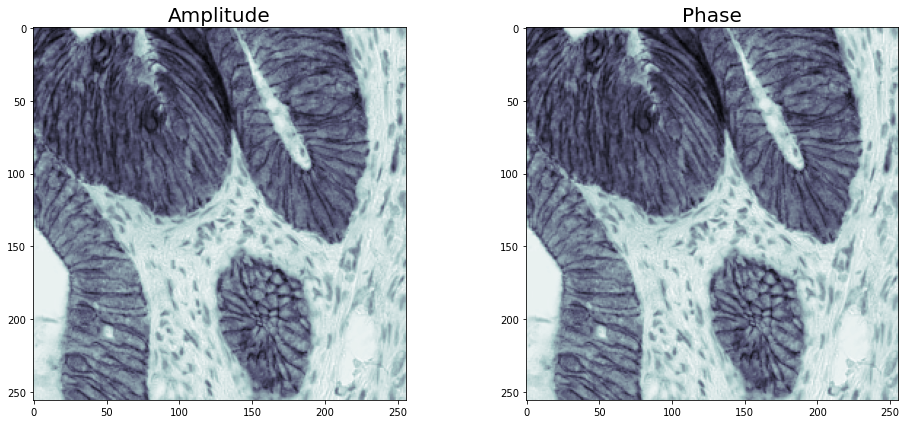

In [71]:
plt.close('all')
Fig1 = plt.figure(1,figsize=(14,6))
ax1 = Fig1.add_subplot(121)
ax1.imshow(np.abs(obj),cmap='bone')
ax1.set_title('Amplitude',fontsize=20)

ax2 = Fig1.add_subplot(122)
ax2.imshow(np.angle(obj),cmap='bone')
ax2.set_title('Phase', fontsize=20)
plt.tight_layout()
plt.show(block=False)

### Simulating the Foward process

In [72]:
imSeqLowRes = forward_fpm(obj,arraysize,waveLength,spsize,psize,NA,LEDgap,LEDheight,epsilon,display=False)

### Implementing the phase retrieval

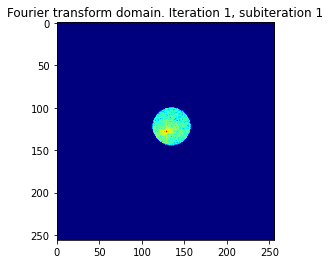

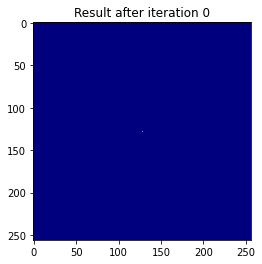

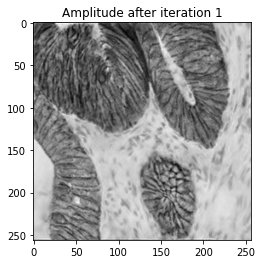

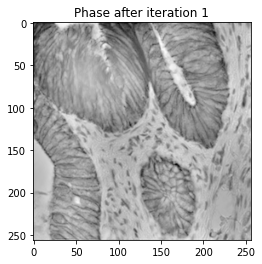

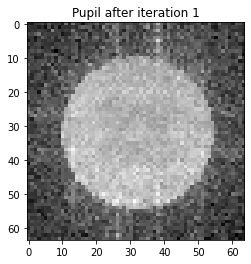

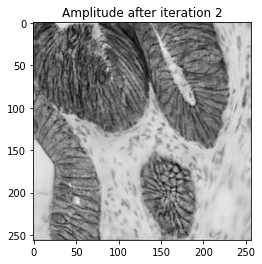

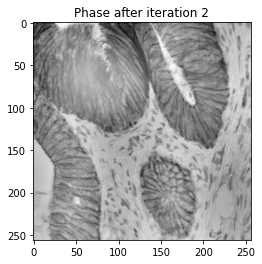

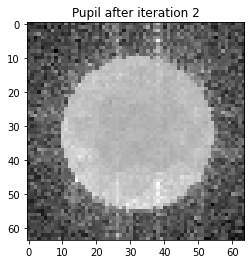

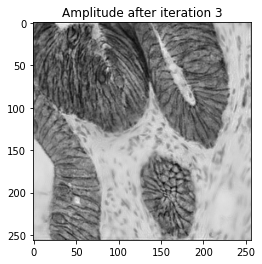

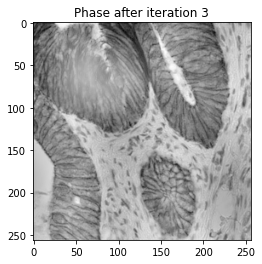

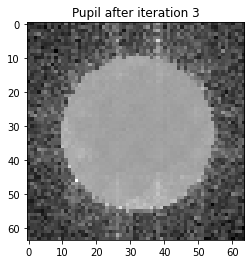

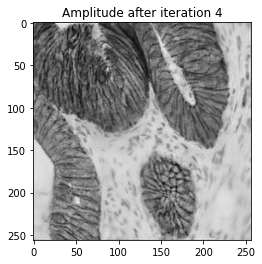

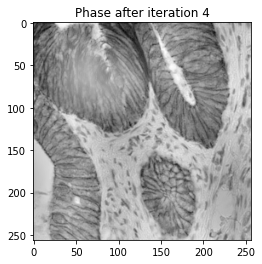

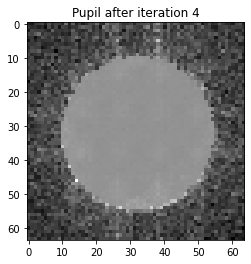

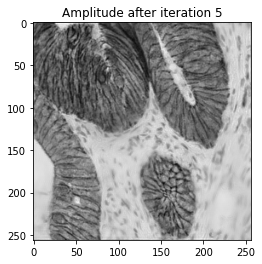

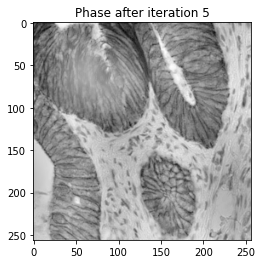

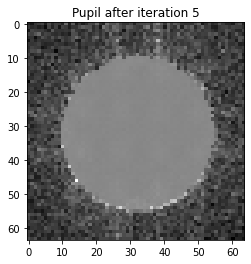

Total time elapsed in the reconstruction using 5 loops: 36.36s


In [73]:
HigResImg,pupil,converIndex = recovery_fpm(imSeqLowRes,arraysize,nloop,waveLength,spsize,psize,NA,LEDgap,LEDheight,epsilon)